In [52]:
import findspark
findspark.init()

import pyspark
import random

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

fileName = "/Users/lingzhuo/Desktop/256/MSFT.csv"

#initial a spark cluster
spark = pyspark.sql.SparkSession.builder.appName("StockPrice").config("spark.some.config.option", "some-value").getOrCreate()

#Use spark.read() to access this. Loads a CSV file and returns the result as a DataFrame.
df = spark.read.csv(fileName, header=True, inferSchema=True)


import pyspark.sql.functions as f
df = df.withColumn('date', f.to_date('Date'))
date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df = df.withColumn(name, f.split('date', '-')[index])
df.show(n=10)


+----------+--------+--------+--------+--------+---------+----------+----+-----+---+
|      date|    Open|    High|     Low|   Close|Adj Close|    Volume|year|month|day|
+----------+--------+--------+--------+--------+---------+----------+----+-----+---+
|1986-03-13|0.088542|0.101563|0.088542|0.097222| 0.062378|1031788800|1986|   03| 13|
|1986-03-14|0.097222|0.102431|0.097222|0.100694| 0.064606| 308160000|1986|   03| 14|
|1986-03-17|0.100694|0.103299|0.100694|0.102431|  0.06572| 133171200|1986|   03| 17|
|1986-03-18|0.102431|0.103299|0.098958|0.099826| 0.064049|  67766400|1986|   03| 18|
|1986-03-19|0.099826|0.100694|0.097222| 0.09809| 0.062935|  47894400|1986|   03| 19|
|1986-03-20| 0.09809| 0.09809|0.094618|0.095486| 0.061264|  58435200|1986|   03| 20|
|1986-03-21|0.095486|0.097222|0.091146|0.092882| 0.059594|  59990400|1986|   03| 21|
|1986-03-24|0.092882|0.092882| 0.08941|0.090278| 0.057923|  65289600|1986|   03| 24|
|1986-03-25|0.090278|0.092014| 0.08941|0.092014| 0.059037|  32083

In [53]:
date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df = df.withColumn(name, f.split('date', '-')[index])
df.show(n=10)

+----------+--------+--------+--------+--------+---------+----------+----+-----+---+
|      date|    Open|    High|     Low|   Close|Adj Close|    Volume|year|month|day|
+----------+--------+--------+--------+--------+---------+----------+----+-----+---+
|1986-03-13|0.088542|0.101563|0.088542|0.097222| 0.062378|1031788800|1986|   03| 13|
|1986-03-14|0.097222|0.102431|0.097222|0.100694| 0.064606| 308160000|1986|   03| 14|
|1986-03-17|0.100694|0.103299|0.100694|0.102431|  0.06572| 133171200|1986|   03| 17|
|1986-03-18|0.102431|0.103299|0.098958|0.099826| 0.064049|  67766400|1986|   03| 18|
|1986-03-19|0.099826|0.100694|0.097222| 0.09809| 0.062935|  47894400|1986|   03| 19|
|1986-03-20| 0.09809| 0.09809|0.094618|0.095486| 0.061264|  58435200|1986|   03| 20|
|1986-03-21|0.095486|0.097222|0.091146|0.092882| 0.059594|  59990400|1986|   03| 21|
|1986-03-24|0.092882|0.092882| 0.08941|0.090278| 0.057923|  65289600|1986|   03| 24|
|1986-03-25|0.090278|0.092014| 0.08941|0.092014| 0.059037|  32083

In [54]:
df_plot = df.select('Close').toPandas()

df_plot.head(10)


,Close
0,0.097222
1,0.100694
2,0.102431
3,0.099826
4,0.098090
5,0.095486
6,0.092882
7,0.090278
8,0.092014
9,0.094618


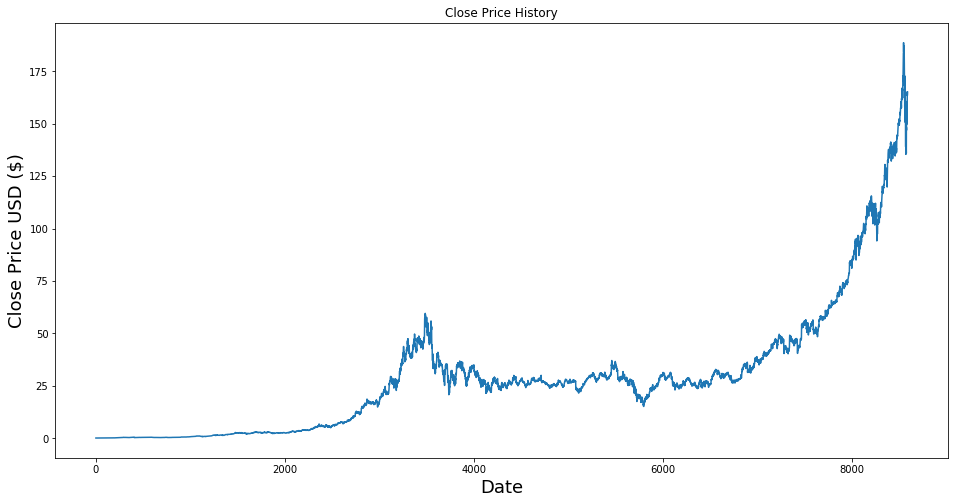

In [55]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df_plot["Close"])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

# prepocessing data

In [56]:
#Create a new dataframe with only the 'Close' column, convert it to np array
#dataset = np.array(df.select('Close').collect())
data = df.select('Close').toPandas()
#Converting the dataframe to a numpy array
dataset = data.values


#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
#[0,59] -> 60 [1,60]->61
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# LSTM

In [57]:
#Reshape the data into the shape accepted by the LSTM:3D
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Build the LSTM network model
#two LSTM layers with 50 neurons and two Dense layers, one with 25 neurons and the other with 1 neuron.
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)


#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
     
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM:3D
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

from pyspark.ml.evaluation import RegressionEvaluator
df = pd.DataFrame(y_test, columns=['Close'])
df['Predict'] = predictions
df_predictions = spark.createDataFrame(df)
rmse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predict", metricName="rmse")
mse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predict", metricName="mse")
mae_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predict", metricName="mae")

#Calculate/Get the value of RMSE
#rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
#rmse

Epoch 1/1
6812/6812 [==============================] - 284s 42ms/step - loss: 8.2775e-05


# result

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


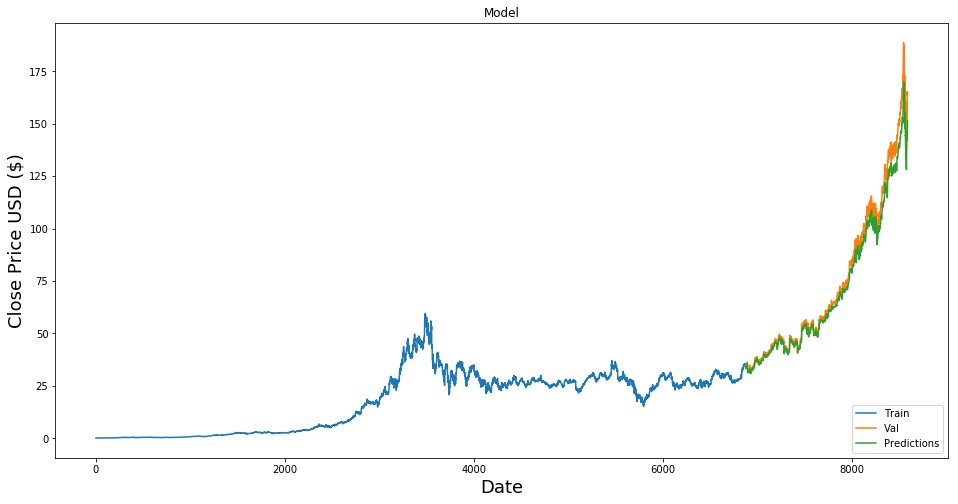

In [58]:
#Plot/Create the data for the graph
#train = data[:training_data_len]
#valid = data[training_data_len:]
train = data.iloc[:training_data_len]
valid = data.iloc[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [59]:
#Show the valid and predicted prices
valid

,Close,Predictions
6872,34.400002,34.370663
6873,35.000000,34.141441
6874,34.980000,34.215687
6875,34.590000,34.325020
6876,33.490002,34.257652
...,...,...
8585,153.830002,142.926544
8586,165.270004,142.136307
8587,163.490005,147.107193
8588,165.130005,149.838669


In [60]:
#predict next day
#Get the quote
#msft_quote = pd.read_csv("MSFT.csv")

fileName = "/Users/lingzhuo/Desktop/256/MSFT.csv"

#spark = pyspark.sql.SparkSession.builder.appName("StockPrice").config("spark.some.config.option", "some-value").getOrCreate()

msft_quote = spark.read.csv(fileName, header=True, inferSchema=True)

#Create a new dataframe
new_df = msft_quote.select('Close').toPandas()

#Get teh last 60 day closing price, Scale the data to be values between 0 and 1
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

#create an empty list and append the past 60 day price to it, 
#and then convert it to a numpy array and reshape it so that I can input the data into the model.
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)


#next day
print(pred_price)

[[152.19604]]
